
Computing Error-Bars to estimate the effect of randomly initialised parameters 
==

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from copy import deepcopy

This notebook runs a simulation once to generate data, then for each estimator run 3 different estimations starting from different coefficients $ \sim \mathcal{N}(\mu,\sigma^2)$  
Choose your Hyper-parameters $\mu$ and $\sigma$

In [21]:
mu = 0.0
sigma = 1.0
np.random.seed(3)

## Generate data

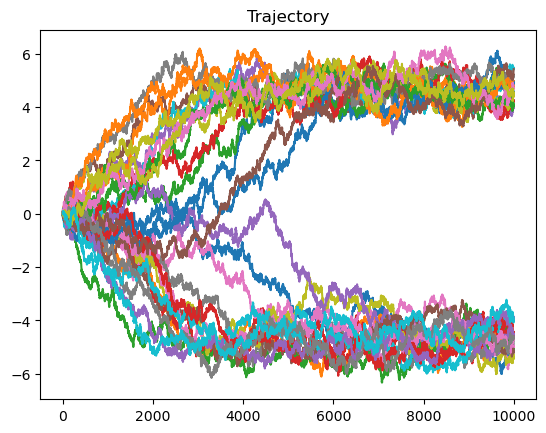

In [16]:
coeff = 0.2 * np.array([0, 0, -4.5, 0, 0.1])
free_energy = np.polynomial.Polynomial(coeff)
D = 0.5
force_coeff = D * np.array([-coeff[1], -2 * coeff[2], -3 * coeff[3], -4 * coeff[4]])

force_function = fl.functions.Polynomial(deg=3, coefficients=force_coeff)
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.array(D))

# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)

# Define model to simulate and type of simulator to use
dt = 1e-3
model_simu = fl.models.overdamped.Overdamped(force_function, diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


# initialize positions
ntraj = 30
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = 0
# Calculate Trajectory
time_steps = 10000
data = simulator.run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")


## Training


### Euler Training 

random [-0.2773882  -0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803
 -1.31386475  0.88462238]
Euler 1 [  4.0876232  -11.66995632  11.80925488  -4.11196813   0.50228205
   0.48226111   0.52446208   0.49032375]
random [ 0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763]
Euler 2 [  4.05617757 -11.57554986  11.8183928   -4.1986603    0.5028748
   0.480654     0.52620423   0.48968995]
random [-1.18504653 -0.2056499   1.48614836  0.23671627 -1.02378514 -0.7129932
  0.62524497 -0.16051336]
Euler 3 [  4.04083755 -11.53702939  11.77111766  -4.1654594    0.50276866
   0.48103359   0.52557019   0.4899564 ]


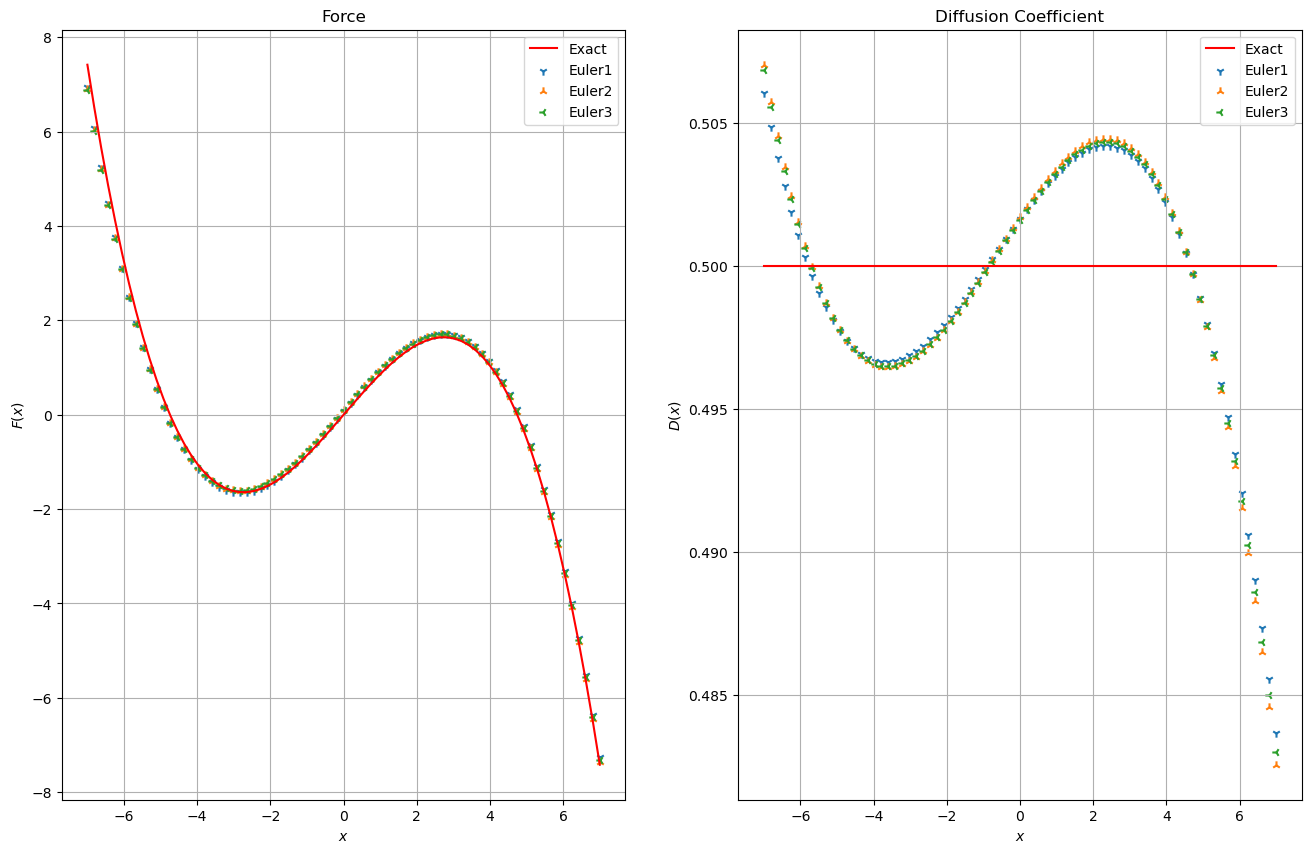

In [26]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Euler_res=[]
markers=['1','2','3']
for index in range(3):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4)
    Euler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Euler',index +1,Euler_res[index].coefficients)
    axs[0].scatter(xfa, Euler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))
    axs[1].scatter(xfa, Euler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))


axs[0].legend()
axs[1].legend()


estimate errorbars

### Elerian training

random [-0.2773882  -0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803
 -1.31386475  0.88462238]
Elerian 1 [-0.2773882  -0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803
 -1.31386475  0.88462238]
random [ 0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763]
Elerian 2 [ 0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763]
random [-1.18504653 -0.2056499   1.48614836  0.23671627 -1.02378514 -0.7129932
  0.62524497 -0.16051336]
Elerian 3 [-1.18504653 -0.2056499   1.48614836  0.23671627 -1.02378514 -0.7129932
  0.62524497 -0.16051336]


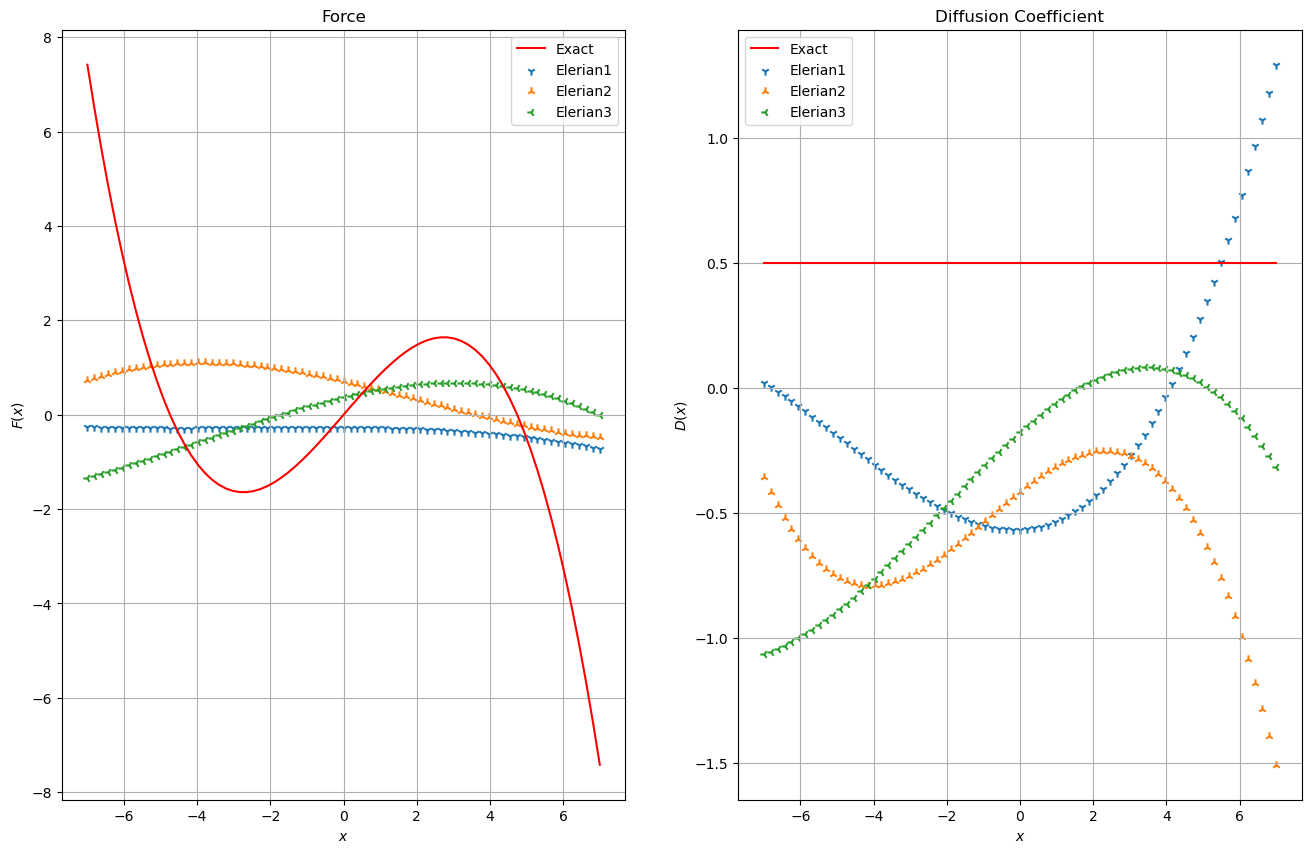

In [27]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Elerian_res=[]
for index in range(3):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.ElerianDensity(trainmodel) ,n_jobs=4)
    Elerian_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Elerian',index +1,Elerian_res[index].coefficients)
    axs[0].scatter(xfa, Elerian_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
    axs[1].scatter(xfa, Elerian_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
axs[0].legend()
axs[1].legend()


### Kessler training

random [-0.2773882  -0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803
 -1.31386475  0.88462238]
Kessler 1 [-0.25059798 -0.33301534  0.00273875 -0.54948394 -0.45656284 -0.34515257
 -2.16177572  2.63471316]
random [ 0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763]
Kessler 2 [  4.03433974 -11.53600953  11.76333317  -4.16162257  -0.50479068
  -0.47892692  -0.52522991  -0.49150275]
random [-1.18504653 -0.2056499   1.48614836  0.23671627 -1.02378514 -0.7129932
  0.62524497 -0.16051336]
Kessler 3 [-1.13222225 -0.16777084  1.56944983  0.17958554 -2.51918017  1.63505656
  0.93514843  0.28175587]


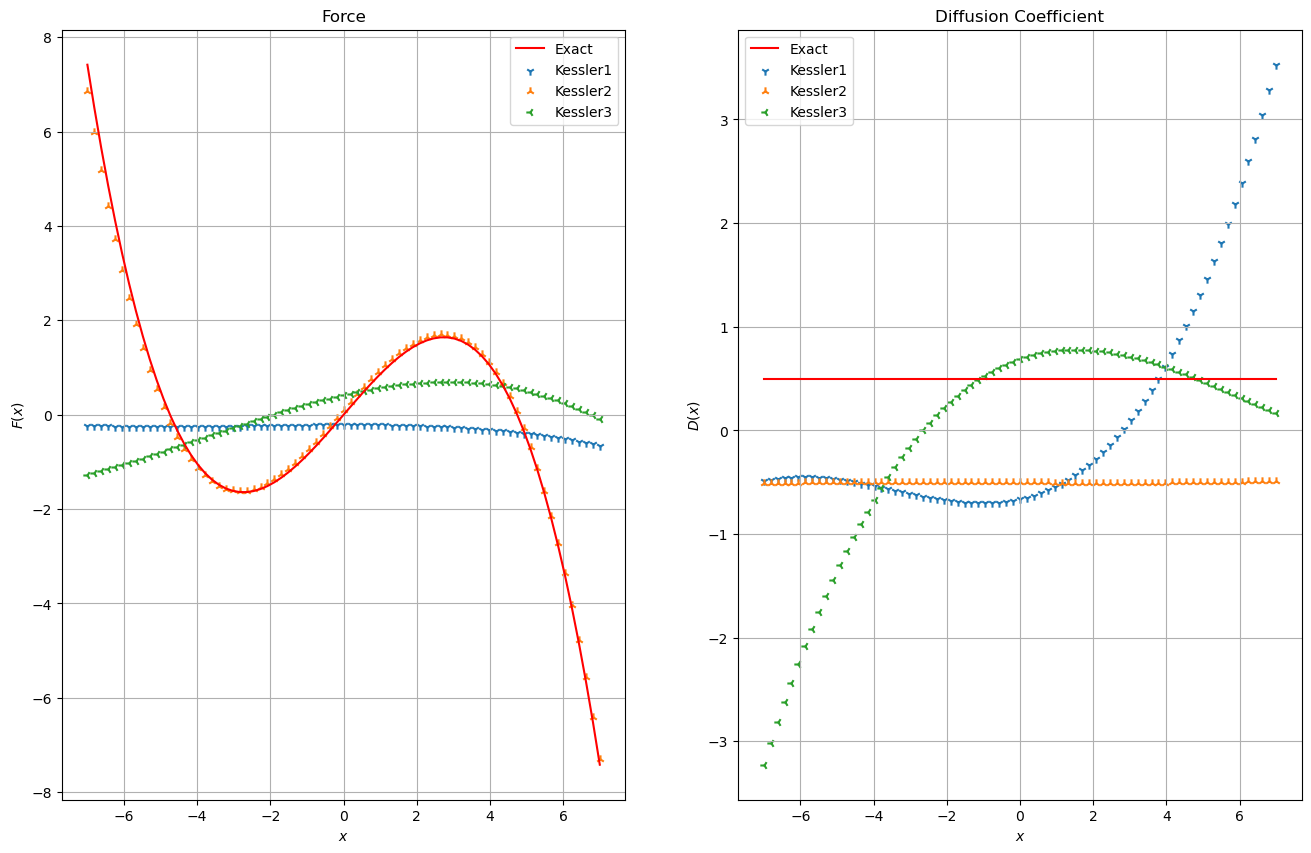

In [28]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Kessler_res=[]
for index in range(3):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel) ,n_jobs=4)
    Kessler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Kessler',index +1,Kessler_res[index].coefficients)
    axs[0].scatter(xfa, Kessler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
    axs[1].scatter(xfa, Kessler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
axs[0].legend()
axs[1].legend()

### Drozdov Training

random [-0.2773882  -0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803
 -1.31386475  0.88462238]
Drozdov 1 [ 0.03395984 -0.1236676   1.22761179  0.76304719 -0.60660694  0.11326298
 -2.67065056  2.74635975]
random [ 0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763]
Drozdov 2 [  4.03461091 -11.52477434  11.75935543  -4.16123419  -0.50450331
  -0.48007198  -0.52418066  -0.4919046 ]
random [-1.18504653 -0.2056499   1.48614836  0.23671627 -1.02378514 -0.7129932
  0.62524497 -0.16051336]
Drozdov 3 [-1.19513141 -0.25983303  1.45431675  0.19820024 -0.01874628 -3.27021008
  4.65849907 -0.09462499]


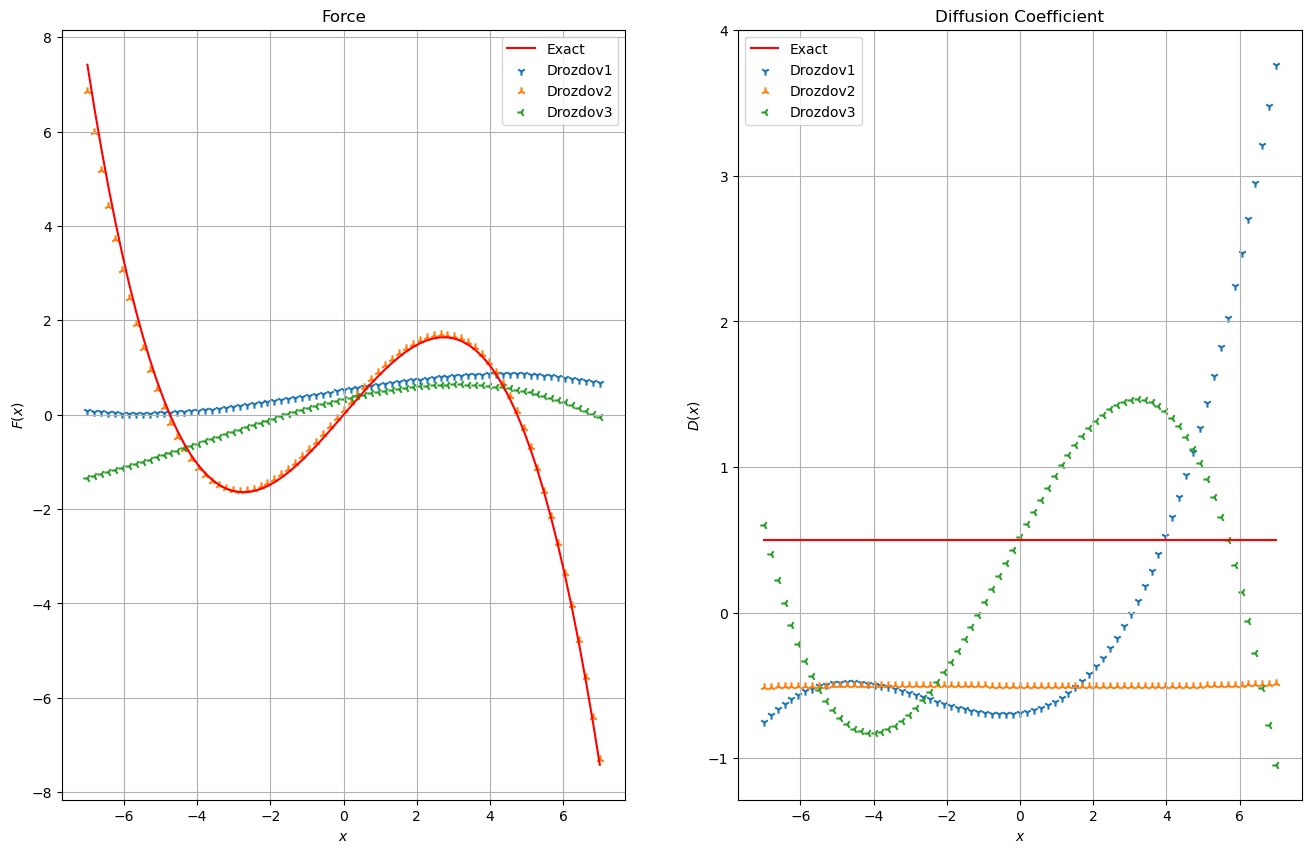

In [29]:
#  DROZDOV
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Drozdov_res=[]
for index in range(3):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(trainmodel) ,n_jobs=4)
    Drozdov_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Drozdov',index +1,Drozdov_res[index].coefficients)
    axs[0].scatter(xfa, Drozdov_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
    axs[1].scatter(xfa, Drozdov_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
axs[0].legend()
axs[1].legend()